# Hotel Cancelation Predictions
#### Data used [here](https://www.kaggle.com/jessemostipak/hotel-booking-demand)


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import warnings 
warnings.filterwarnings('ignore')

In [74]:
hotel = pd.read_csv('./data_files/hotel_bookings.csv')
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [75]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [76]:
hotel.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### Filling Children missing values with the mean 

In [77]:
hotel['children'].fillna(hotel['children'].mean(),inplace=True)
hotel['agent'].fillna(hotel['agent'].mean(),inplace=True)
hotel['country'].fillna(0, inplace=True)
hotel['company'].fillna(0, inplace=True)

In [78]:
hotel.isnull().any().any()

False

In [79]:
cancels = hotel.groupby(['is_canceled','hotel']).mean()['days_in_waiting_list'].reset_index()
cancels['is_canceled'].replace({0: 'No', 1: 'Yes'}, inplace=True)
cancels

,is_canceled,hotel,days_in_waiting_list
0,No,City Hotel,2.150082
1,No,Resort Hotel,0.694934
2,Yes,City Hotel,4.730409
3,Yes,Resort Hotel,0.092789


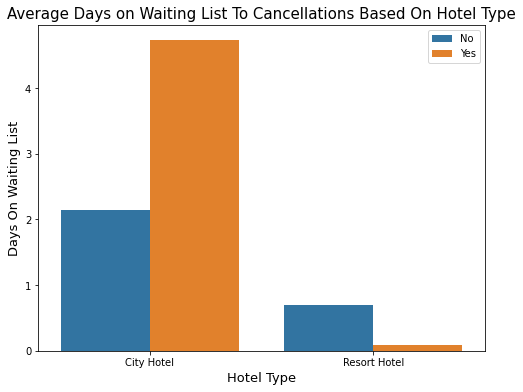

From this graph people are more likely to cancel on a normal city hotel rather than a resort hotel as these are mostlikly
harder to get and possibly more expensive


In [80]:
plt.figure(figsize=(8,6))
sns.barplot(cancels['hotel'], cancels['days_in_waiting_list'], hue=cancels['is_canceled'])
plt.title('Average Days on Waiting List To Cancellations Based On Hotel Type', fontsize=15)
plt.xlabel('Hotel Type', fontsize=13)
plt.ylabel('Days On Waiting List', fontsize=13)
plt.legend()
plt.show()
print('''From this graph people are more likely to cancel on a normal city hotel rather than a resort hotel as these are mostlikly
harder to get and possibly more expensive''')

In [81]:
years = hotel.groupby(['arrival_date_year', 'hotel']).count().reset_index()
years['arrival_date_year'] = years['arrival_date_year'].astype(str)
years

,arrival_date_year,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,2015,City Hotel,13682,13682,13682,13682,13682,13682,13682,13682,...,13682,13682,13682,13682,13682,13682,13682,13682,13682,13682
1,2015,Resort Hotel,8314,8314,8314,8314,8314,8314,8314,8314,...,8314,8314,8314,8314,8314,8314,8314,8314,8314,8314
2,2016,City Hotel,38140,38140,38140,38140,38140,38140,38140,38140,...,38140,38140,38140,38140,38140,38140,38140,38140,38140,38140
3,2016,Resort Hotel,18567,18567,18567,18567,18567,18567,18567,18567,...,18567,18567,18567,18567,18567,18567,18567,18567,18567,18567
4,2017,City Hotel,27508,27508,27508,27508,27508,27508,27508,27508,...,27508,27508,27508,27508,27508,27508,27508,27508,27508,27508
5,2017,Resort Hotel,13179,13179,13179,13179,13179,13179,13179,13179,...,13179,13179,13179,13179,13179,13179,13179,13179,13179,13179


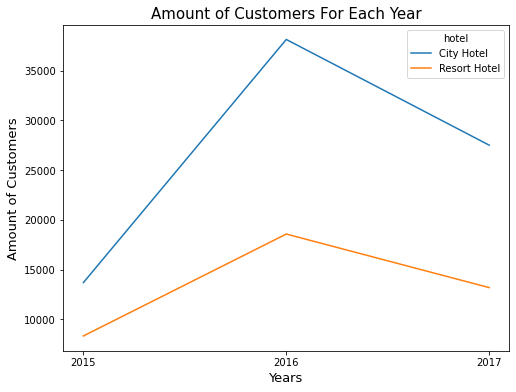

In most cases a city hotel is going to be used more often than a resort so that is clear as to why it has more customers. 
However, they both have a spike in 2016 from 2015 and a slight drop off in 2017.


In [82]:
plt.figure(figsize=(8,6))
sns.lineplot(years['arrival_date_year'], years['is_canceled'],hue=years['hotel'])
plt.xlabel('Years', fontsize=13)
plt.ylabel('Amount of Customers', fontsize=13)
plt.title('Amount of Customers For Each Year', fontsize=15)
plt.show()
print('''In most cases a city hotel is going to be used more often than a resort so that is clear as to why it has more customers. 
However, they both have a spike in 2016 from 2015 and a slight drop off in 2017.''')

In [83]:
best_month = hotel.groupby(['arrival_date_month']).count().sort_values(by='arrival_date_month').reset_index().sort_values(by='hotel')
best_month

,arrival_date_month,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
4,January,5929,5929,5929,5929,5929,5929,5929,5929,5929,...,5929,5929,5929,5929,5929,5929,5929,5929,5929,5929
2,December,6780,6780,6780,6780,6780,6780,6780,6780,6780,...,6780,6780,6780,6780,6780,6780,6780,6780,6780,6780
9,November,6794,6794,6794,6794,6794,6794,6794,6794,6794,...,6794,6794,6794,6794,6794,6794,6794,6794,6794,6794
3,February,8068,8068,8068,8068,8068,8068,8068,8068,8068,...,8068,8068,8068,8068,8068,8068,8068,8068,8068,8068
7,March,9794,9794,9794,9794,9794,9794,9794,9794,9794,...,9794,9794,9794,9794,9794,9794,9794,9794,9794,9794
11,September,10508,10508,10508,10508,10508,10508,10508,10508,10508,...,10508,10508,10508,10508,10508,10508,10508,10508,10508,10508
6,June,10939,10939,10939,10939,10939,10939,10939,10939,10939,...,10939,10939,10939,10939,10939,10939,10939,10939,10939,10939
0,April,11089,11089,11089,11089,11089,11089,11089,11089,11089,...,11089,11089,11089,11089,11089,11089,11089,11089,11089,11089
10,October,11160,11160,11160,11160,11160,11160,11160,11160,11160,...,11160,11160,11160,11160,11160,11160,11160,11160,11160,11160
8,May,11791,11791,11791,11791,11791,11791,11791,11791,11791,...,11791,11791,11791,11791,11791,11791,11791,11791,11791,11791


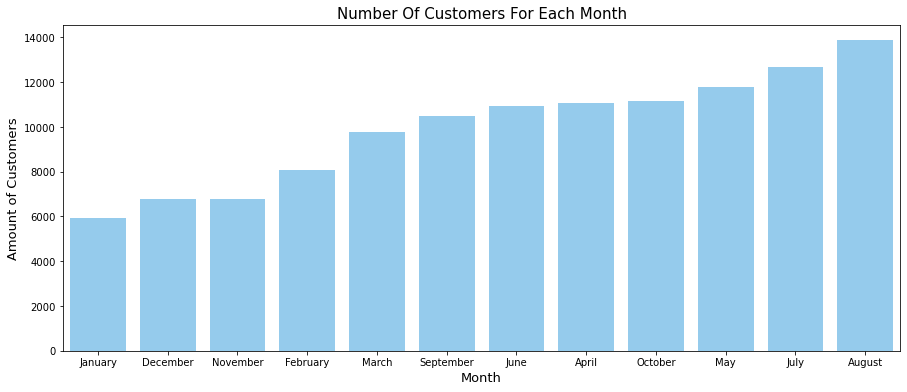

Based on this graph August is the hotels best months for sales and January is their most lacking month. 
With this information they could look at ways to increase sales in January and around the end of the year/new year. 


In [84]:
plt.figure(figsize=(15,6))
sns.barplot(best_month['arrival_date_month'], best_month['hotel'], color='lightskyblue')
plt.title('Number Of Customers For Each Month', fontsize=15)
plt.xlabel('Month',fontsize=13)
plt.ylabel('Amount of Customers',fontsize=13)
plt.show()
print('''Based on this graph August is the hotels best months for sales and January is their most lacking month. 
With this information they could look at ways to increase sales in January and around the end of the year/new year. ''')

In [85]:
hotel.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [114]:
best_month = hotel.groupby(['arrival_date_month','arrival_date_year']).count().sort_values(by='arrival_date_month').reset_index().sort_values(by='hotel')
best_month

,arrival_date_month,arrival_date_year,hotel,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
9,January,2016,2248,2248,2248,2248,2248,2248,2248,2248,...,2248,2248,2248,2248,2248,2248,2248,2248,2248,2248
20,November,2015,2340,2340,2340,2340,2340,2340,2340,2340,...,2340,2340,2340,2340,2340,2340,2340,2340,2340,2340
13,July,2015,2776,2776,2776,2776,2776,2776,2776,2776,...,2776,2776,2776,2776,2776,2776,2776,2776,2776,2776
5,December,2015,2920,2920,2920,2920,2920,2920,2920,2920,...,2920,2920,2920,2920,2920,2920,2920,2920,2920,2920
10,January,2017,3681,3681,3681,3681,3681,3681,3681,3681,...,3681,3681,3681,3681,3681,3681,3681,3681,3681,3681
6,December,2016,3860,3860,3860,3860,3860,3860,3860,3860,...,3860,3860,3860,3860,3860,3860,3860,3860,3860,3860
2,August,2015,3889,3889,3889,3889,3889,3889,3889,3889,...,3889,3889,3889,3889,3889,3889,3889,3889,3889,3889
7,February,2016,3891,3891,3891,3891,3891,3891,3891,3891,...,3891,3891,3891,3891,3891,3891,3891,3891,3891,3891
8,February,2017,4177,4177,4177,4177,4177,4177,4177,4177,...,4177,4177,4177,4177,4177,4177,4177,4177,4177,4177
21,November,2016,4454,4454,4454,4454,4454,4454,4454,4454,...,4454,4454,4454,4454,4454,4454,4454,4454,4454,4454


Text(0.5, 0, 'Months')

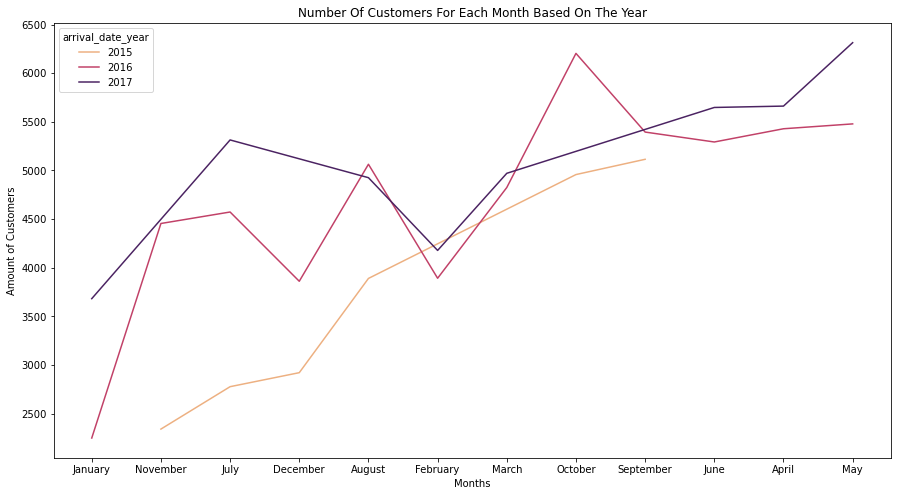

In [116]:
plt.figure(figsize=(15,8))
colors = ['Red','Orange', 'Yellow']
sns.lineplot(best_month['arrival_date_month'],best_month['hotel'],hue=best_month['arrival_date_year'],palette='flare')
plt.ylabel('Amount of Customers')
plt.title('Number Of Customers For Each Month Based On The Year')
plt.xlabel('Months')

# Matchine Learning

### Useful columns for models

In [27]:
hotel.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [28]:
hotel['reservation_status'].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

### Market segment and Distribution Channel tell a similar story and will add to many ohe columns so these are dropped 

In [29]:
hotel.drop(columns=['market_segment', 'distribution_channel'], inplace=True)

### Country Column has to be dropped since there are to many countries to OHE unless a PCA is used

In [30]:
hotel.drop(columns=['country'], inplace=True)

### Good for visualizations not so much for model predictions, Redundent columns or columns that are not needed for model predictions

In [31]:
hotel.drop(columns=['reserved_room_type', 'assigned_room_type', 'adr', 'reservation_status_date', 'meal', 'previous_bookings_not_canceled','required_car_parking_spaces', 'total_of_special_requests', 'lead_time', 'stays_in_weekend_nights','stays_in_week_nights'], inplace=True)

In [32]:
hotel.drop(columns=['arrival_date_week_number', 'arrival_date_day_of_month','adults','children', 'babies','arrival_date_month'], inplace=True)

In [33]:
hotel.columns #44

Index(['hotel', 'is_canceled', 'arrival_date_year', 'is_repeated_guest',
       'previous_cancellations', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type',
       'reservation_status'],
      dtype='object')

In [34]:
hotel.dtypes 

hotel                      object
is_canceled                 int64
arrival_date_year           int64
is_repeated_guest           int64
previous_cancellations      int64
booking_changes             int64
deposit_type               object
agent                     float64
company                   float64
days_in_waiting_list        int64
customer_type              object
reservation_status         object
dtype: object

In [53]:
X = hotel.drop(columns='is_canceled')
y = hotel['is_canceled']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)

In [55]:
cat_feat = make_column_selector(dtype_include='object')

quat_feat = make_column_selector(dtype_include='number')

ohe= OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

column_transformer = make_column_transformer((ohe, cat_feat), (scaler, quat_feat))

# KNN Model

In [56]:
knn_base = make_pipeline(column_transformer, KNeighborsClassifier())

knn_base.fit(X_train,y_train)

print(f'Traning: {knn_base.score(X_train, y_train)}')
print(f'Testing: {knn_base.score(X_test, y_test)}')

Traning: 0.9984699917357218
Testing: 0.9976212811578665


In [59]:
y_pred = knn_base.predict(X_test)
class_rep = classification_report(y_test, y_pred)
print(class_rep)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18792
           1       1.00      0.99      1.00     11056

    accuracy                           1.00     29848
   macro avg       1.00      1.00      1.00     29848
weighted avg       1.00      1.00      1.00     29848



# Boosting

In [57]:
xgb_pipe = make_pipeline(column_transformer, XGBClassifier())

xgb_pipe.fit(X_train,y_train)

print(f'Traning: {xgb_pipe.score(X_train, y_train)}')
print(f'Testing: {xgb_pipe.score(X_test, y_test)}')

[11:19:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Traning: 1.0
Testing: 1.0


In [58]:
y_pred = xgb_pipe.predict(X_test)
class_rep = classification_report(y_test, y_pred)
print(class_rep)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18792
           1       1.00      1.00      1.00     11056

    accuracy                           1.00     29848
   macro avg       1.00      1.00      1.00     29848
weighted avg       1.00      1.00      1.00     29848



### Possible over fitting so im tracking how many values its actually getting correct with predicting with the data ( X AND Y)

In [40]:
preds = xgb_pipe.predict(X)

preds_correct = pd.DataFrame({'Preds': preds, 'Actual' : y })

# All preds start as False until decided later if they match the actual value
preds_correct['Condition'] = False

#Checks if Pred value matches the Actual value and sets it to True if they match
preds_correct.loc[preds_correct['Preds'] == preds_correct['Actual'], 'Condition'] = 'True'
preds_correct.head()


,Preds,Actual,Condition
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True


#### Since there are no False values that means the model got them all correct

In [41]:
preds_correct['Condition'].value_counts()

True    119390
Name: Condition, dtype: int64

#### Checking the distribution between 0 and 1 values since all I can see from tail and head are 0's 

In [42]:
preds_correct['Actual'].value_counts()

0    75166
1    44224
Name: Actual, dtype: int64

## PCA & LOG REG

In [60]:
X = hotel.drop(columns='is_canceled')
y = hotel['is_canceled']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)

In [62]:
scaler = StandardScaler()
scaled_X_train = X_train.drop(columns=['hotel','is_repeated_guest', 'deposit_type','customer_type', 'reservation_status'])
scaled_X_test = X_test.drop(columns=['hotel','is_repeated_guest', 'deposit_type','customer_type', 'reservation_status'])

scaler.fit(scaled_X_train)


scaled_train = scaler.transform(scaled_X_train)
scaled_test = scaler.transform(scaled_X_test)

In [63]:
pca = PCA(.95)
X_train_pca = pca.fit_transform(scaled_train)
X_test_pca = pca.transform(scaled_test)

In [64]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cols = X_train[['hotel','is_repeated_guest', 'deposit_type','customer_type', 'reservation_status']]
X_test_cols = X_test[['hotel','is_repeated_guest', 'deposit_type','customer_type', 'reservation_status']]

ohe.fit(X_train_cols)

train_cols = ohe.transform(X_train_cols)
test_cols = ohe.transform(X_test_cols)

In [65]:
X_train = np.concatenate((X_train_pca, train_cols), axis=1)
X_test = np.concatenate((X_test_pca, test_cols), axis=1)

In [66]:
log_reg = LogisticRegression()

log_reg.fit(X_train,y_train)

print(f'Traning: {log_reg.score(X_train, y_train)}')
print(f'Testing: {log_reg.score(X_test, y_test)}')

Traning: 1.0
Testing: 1.0


In [67]:
y_pred = log_reg.predict(X_test)
class_rep = classification_report(y_test, y_pred)
print(class_rep)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18792
           1       1.00      1.00      1.00     11056

    accuracy                           1.00     29848
   macro avg       1.00      1.00      1.00     29848
weighted avg       1.00      1.00      1.00     29848

